In [1]:
import os
import pandas as pd
import numpy as np

data_folder = "rsna-breast-cancer-detection"

train_path = os.path.join(data_folder, "train.csv")

if os.path.exists(train_path):
    df = pd.read_csv(train_path)
    print(df.head())
else:
    print("train.csv file not exists:", train_path)
    
train_data = os.path.join(data_folder,"train_images")
print(len(os.listdir(train_data)))


   site_id  patient_id    image_id laterality view   age  cancer  biopsy  \
0        2       10006   462822612          L   CC  61.0       0       0   
1        2       10006  1459541791          L  MLO  61.0       0       0   
2        2       10006  1864590858          R  MLO  61.0       0       0   
3        2       10006  1874946579          R   CC  61.0       0       0   
4        2       10011   220375232          L   CC  55.0       0       0   

   invasive  BIRADS  implant density  machine_id  difficult_negative_case  
0         0     NaN        0     NaN          29                    False  
1         0     NaN        0     NaN          29                    False  
2         0     NaN        0     NaN          29                    False  
3         0     NaN        0     NaN          29                    False  
4         0     0.0        0     NaN          21                     True  
11913


In [2]:

csv_ids = set(df["patient_id"].astype(str))

folder_ids = set(os.listdir(train_data))

missing_in_csv = folder_ids - csv_ids

missing_in_folder = csv_ids - folder_ids

print(len(missing_in_folder))


0


Single_example

=== DICOM Metadata ===
Dataset.file_meta -------------------------------
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002,0003) Media Storage SOP Instance UID      UI: 1.2.840.10009.1.2.3.5.1.640805896
(0002,0010) Transfer Syntax UID                 UI: JPEG 2000 Image Compression (Lossless Only)
(0002,0012) Implementation Class UID            UI: 1.2.840.113654.2.3.1995.2.12.0
(0002,0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008,0018) SOP Instance UID                    UI: 1.2.840.10009.1.2.3.5.1.640805896
(0008,0023) Content Date                        DA: '20221118'
(0008,0033) Content Time                        TM: '184950.680341'
(0010,0020) Patient ID                          LO: '5'
(0020,000D) Study Instance UID                  UI: 1.2.840.10009.1.2.3.5
(0020,000E) Series Instance UID   

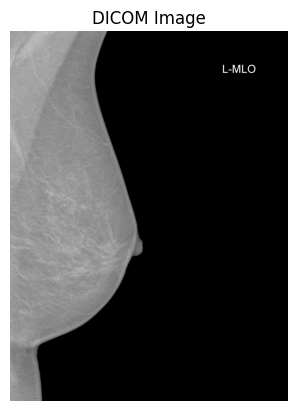

In [3]:
import pydicom
import matplotlib.pyplot as plt

dcm_path = os.path.join(data_folder, "train_images", "5", "640805896.dcm")
d = pydicom.dcmread(dcm_path)
print("=== DICOM Metadata ===")
print(d)

plt.imshow(d.pixel_array, cmap='gray')
plt.title("DICOM Image")
plt.axis("off")
plt.show()


Cancer column value distribution:
0 (no cancer): 53548
1 (cancer): 1158

Total: 54706

Percentage:
0 (no cancer): 97.88%
1 (cancer): 2.12%


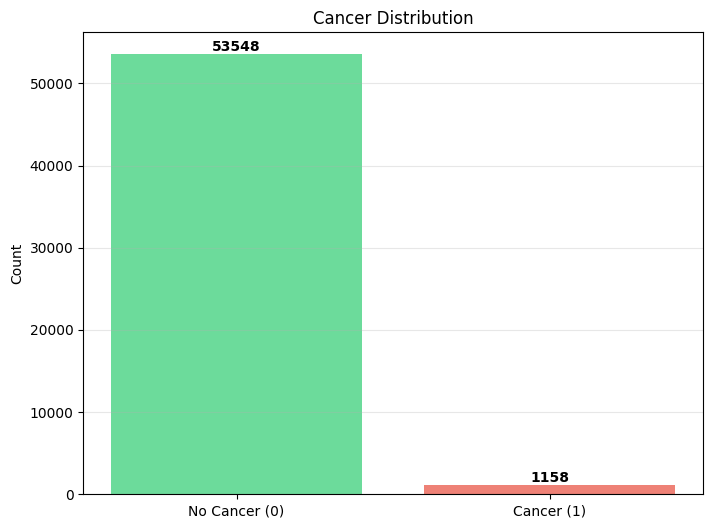

In [7]:
# Count the number of 1s and 0s in the cancer column
cancer_counts = df["cancer"].value_counts()
print("Cancer column value distribution:")
print(f"0 (no cancer): {cancer_counts.get(0, 0)}")
print(f"1 (cancer): {cancer_counts.get(1, 0)}")
print(f"\nTotal: {len(df)}")
print(f"\nPercentage:")
print(f"0 (no cancer): {cancer_counts.get(0, 0) / len(df) * 100:.2f}%")
print(f"1 (cancer): {cancer_counts.get(1, 0) / len(df) * 100:.2f}%")

# Display bar chart
import matplotlib.pyplot as plt

labels = ['No Cancer (0)', 'Cancer (1)']
counts = [cancer_counts.get(0, 0), cancer_counts.get(1, 0)]
colors = ['#2ecc71', '#e74c3c']

plt.figure(figsize=(8, 6))
plt.bar(labels, counts, color=colors, alpha=0.7)
plt.ylabel('Count')
plt.title('Cancer Distribution')
plt.grid(axis='y', alpha=0.3)
for i, v in enumerate(counts):
    plt.text(i, v, str(v), ha='center', va='bottom', fontweight='bold')
plt.show()



Original records: 54706
After deduplication: 11913 unique patients
Age statistics for No Cancer (0):
  Count: 11419
  Mean: 58.43
  Median: 58.00
  Std: 9.83

Age statistics for Cancer (1):
  Count: 486
  Mean: 63.49
  Median: 64.00
  Std: 9.88


C:\Users\Administrator\AppData\Local\Temp\ipykernel_111648\2341962989.py:64: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 0].boxplot(box_data, labels=['No Cancer (0)', 'Cancer (1)'], patch_artist=True,


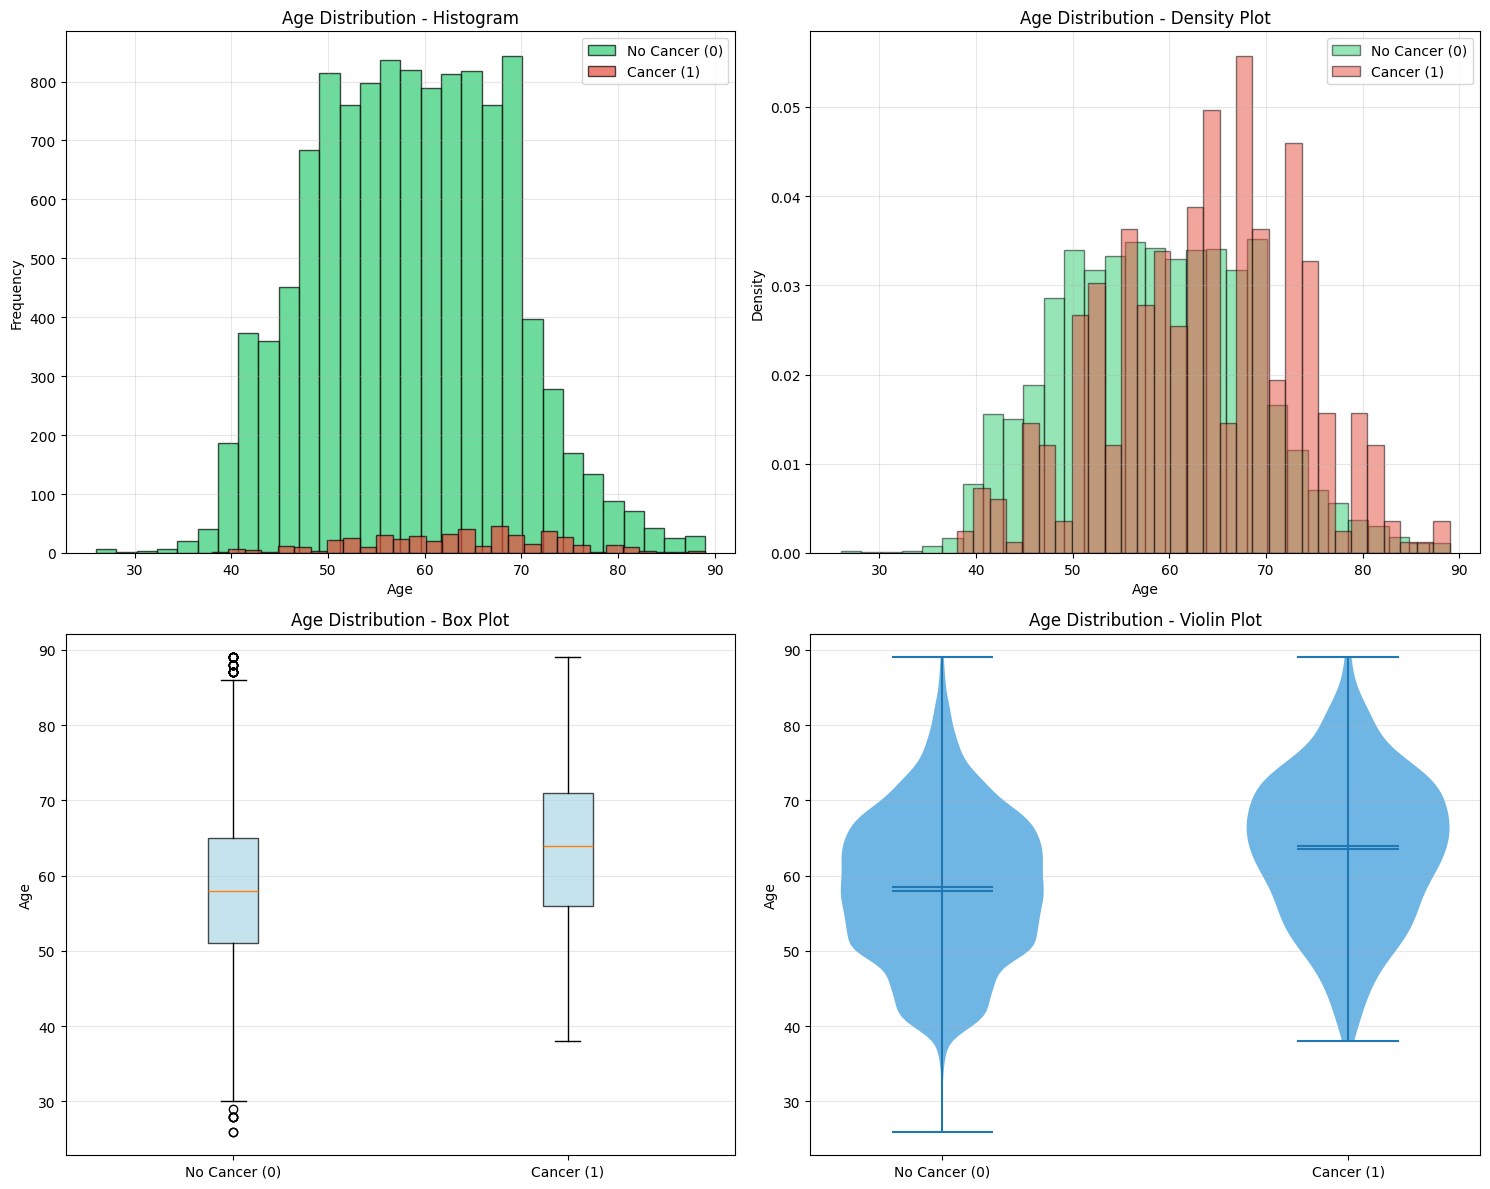

In [21]:
# Preprocess df: if a patient_id has any record with cancer=1, mark as cancer
# Then deduplicate by patient_id (keep one record per patient)
import matplotlib.pyplot as plt
import numpy as np

# Group by patient_id and take max(cancer) - if any record has cancer=1, patient has cancer
df_processed = df.groupby('patient_id').agg({
    'cancer': 'max',  # If any record has cancer=1, result is 1
    'age': 'first',   # Take first age value (assuming same patient has same age)
    # Keep other columns if needed, or just keep patient_id, cancer, age
}).reset_index()

# If you want to keep all columns, you can use:
# df_processed = df.groupby('patient_id').agg({
#     'cancer': 'max',
#     'age': 'first',
#     'site_id': 'first',
#     'biopsy': 'max',
#     'invasive': 'max',
#     # ... other columns
# }).reset_index()

print(f"Original records: {len(df)}")
print(f"After deduplication: {len(df_processed)} unique patients")

# Separate age data by cancer status from processed data
age_no_cancer = df_processed[df_processed['cancer'] == 0]['age'].dropna()
age_cancer = df_processed[df_processed['cancer'] == 1]['age'].dropna()

print(f"Age statistics for No Cancer (0):")
print(f"  Count: {len(age_no_cancer)}")
print(f"  Mean: {age_no_cancer.mean():.2f}")
print(f"  Median: {age_no_cancer.median():.2f}")
print(f"  Std: {age_no_cancer.std():.2f}")
print(f"\nAge statistics for Cancer (1):")
print(f"  Count: {len(age_cancer)}")
print(f"  Mean: {age_cancer.mean():.2f}")
print(f"  Median: {age_cancer.median():.2f}")
print(f"  Std: {age_cancer.std():.2f}")

# Create subplots for different visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Histogram comparison
axes[0, 0].hist(age_no_cancer, bins=30, alpha=0.7, label='No Cancer (0)', color='#2ecc71', edgecolor='black')
axes[0, 0].hist(age_cancer, bins=30, alpha=0.7, label='Cancer (1)', color='#e74c3c', edgecolor='black')
axes[0, 0].set_xlabel('Age')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Age Distribution - Histogram')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Density plot (KDE)
axes[0, 1].hist(age_no_cancer, bins=30, alpha=0.5, label='No Cancer (0)', color='#2ecc71', density=True, edgecolor='black')
axes[0, 1].hist(age_cancer, bins=30, alpha=0.5, label='Cancer (1)', color='#e74c3c', density=True, edgecolor='black')
axes[0, 1].set_xlabel('Age')
axes[0, 1].set_ylabel('Density')
axes[0, 1].set_title('Age Distribution - Density Plot')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Box plot
box_data = [age_no_cancer, age_cancer]
axes[1, 0].boxplot(box_data, labels=['No Cancer (0)', 'Cancer (1)'], patch_artist=True,
                   boxprops=dict(facecolor='lightblue', alpha=0.7))
axes[1, 0].set_ylabel('Age')
axes[1, 0].set_title('Age Distribution - Box Plot')
axes[1, 0].grid(alpha=0.3, axis='y')

# 4. Violin plot
parts = axes[1, 1].violinplot([age_no_cancer, age_cancer], positions=[1, 2], 
                              showmeans=True, showmedians=True)
axes[1, 1].set_xticks([1, 2])
axes[1, 1].set_xticklabels(['No Cancer (0)', 'Cancer (1)'])
axes[1, 1].set_ylabel('Age')
axes[1, 1].set_title('Age Distribution - Violin Plot')
axes[1, 1].grid(alpha=0.3, axis='y')

# Color the violin plots
for pc in parts['bodies']:
    pc.set_facecolor('#3498db')
    pc.set_alpha(0.7)

plt.tight_layout()
plt.show()


Density distribution for No Cancer (0):
density
A       3052
B      12342
C      11898
D       1514
NaN    24742
Name: count, dtype: int64

Density distribution for Cancer (1):
density
A       53
B      309
C      277
D       25
NaN    494
Name: count, dtype: int64

Percentage distribution for No Cancer (0):
density
A       5.70
B      23.05
C      22.22
D       2.83
NaN    46.21
Name: count, dtype: float64

Percentage distribution for Cancer (1):
density
A       4.58
B      26.68
C      23.92
D       2.16
NaN    42.66
Name: count, dtype: float64


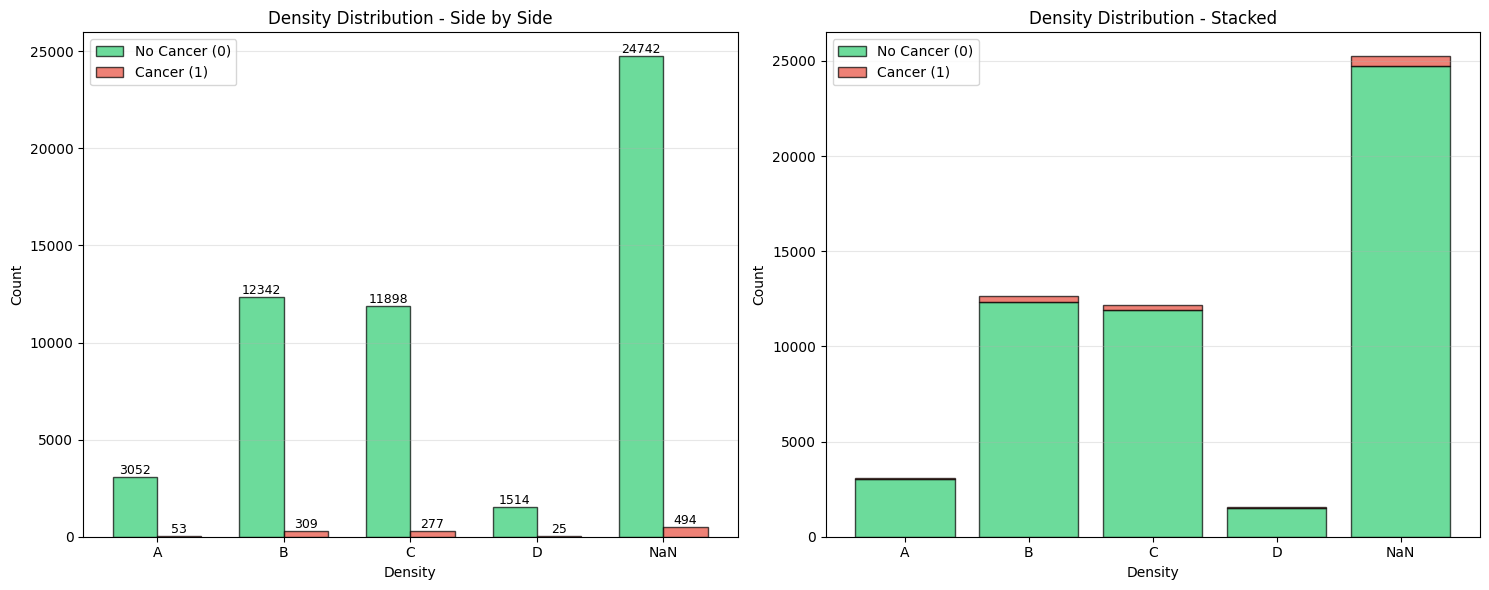

In [22]:
# Display density distribution (A, B, C, D, NaN) for cancer and non-cancer patients
# Using original df (no deduplication)
import matplotlib.pyplot as plt
import numpy as np

# Replace NaN with 'NaN' string for easier handling
df_density = df.copy()
df_density['density'] = df_density['density'].fillna('NaN')

# Separate data by cancer status
density_no_cancer = df_density[df_density['cancer'] == 0]['density']
density_cancer = df_density[df_density['cancer'] == 1]['density']

# Count density values for each group
density_counts_no_cancer = density_no_cancer.value_counts().sort_index()
density_counts_cancer = density_cancer.value_counts().sort_index()

# Ensure all categories (A, B, C, D, NaN) are present in both
all_categories = ['A', 'B', 'C', 'D', 'NaN']
density_counts_no_cancer = density_counts_no_cancer.reindex(all_categories, fill_value=0)
density_counts_cancer = density_counts_cancer.reindex(all_categories, fill_value=0)

print("Density distribution for No Cancer (0):")
print(density_counts_no_cancer)
print(f"\nDensity distribution for Cancer (1):")
print(density_counts_cancer)

# Calculate percentages
print("\nPercentage distribution for No Cancer (0):")
print((density_counts_no_cancer / len(density_no_cancer) * 100).round(2))
print("\nPercentage distribution for Cancer (1):")
print((density_counts_cancer / len(density_cancer) * 100).round(2))

# Create visualizations
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. Side-by-side bar chart
x = np.arange(len(all_categories))
width = 0.35

axes[0].bar(x - width/2, density_counts_no_cancer.values, width, label='No Cancer (0)', 
            color='#2ecc71', alpha=0.7, edgecolor='black')
axes[0].bar(x + width/2, density_counts_cancer.values, width, label='Cancer (1)', 
            color='#e74c3c', alpha=0.7, edgecolor='black')

axes[0].set_xlabel('Density')
axes[0].set_ylabel('Count')
axes[0].set_title('Density Distribution - Side by Side')
axes[0].set_xticks(x)
axes[0].set_xticklabels(all_categories)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (val1, val2) in enumerate(zip(density_counts_no_cancer.values, density_counts_cancer.values)):
    if val1 > 0:
        axes[0].text(i - width/2, val1, str(int(val1)), ha='center', va='bottom', fontsize=9)
    if val2 > 0:
        axes[0].text(i + width/2, val2, str(int(val2)), ha='center', va='bottom', fontsize=9)

# 2. Stacked bar chart
axes[1].bar(all_categories, density_counts_no_cancer.values, label='No Cancer (0)', 
             color='#2ecc71', alpha=0.7, edgecolor='black')
axes[1].bar(all_categories, density_counts_cancer.values, bottom=density_counts_no_cancer.values,
            label='Cancer (1)', color='#e74c3c', alpha=0.7, edgecolor='black')

axes[1].set_xlabel('Density')
axes[1].set_ylabel('Count')
axes[1].set_title('Density Distribution - Stacked')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
print(len(df[df['difficult_negative_case'] == True]))


7705


In [ ]:
print(df['patient_id'].value_counts())

patient_id
52868    14
55706    14
44047    13
26530    13
5421     13
         ..
10151     4
10152     4
10153     4
10175     4
10179     4
Name: count, Length: 11913, dtype: int64


patient count is different

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# get patient_id
patient_ids = df["patient_id"].unique()

#  8:2（先分出 val+test）
train_ids, val_test_ids = train_test_split(
    patient_ids,
    test_size=0.2,      # 20% → val + test
    random_state=42,
    shuffle=True
)

#  20% val / test（1:1）
val_ids, test_ids = train_test_split(
    val_test_ids,
    test_size=0.5,      # 50%->val+test
    random_state=42,
    shuffle=True
)

print("Train patients:", len(train_ids))
print("Val patients:", len(val_ids))
print("Test patients:", len(test_ids))


Train patients: 9530
Val patients: 1191
Test patients: 1192
